Plan: compare MSE of (rescaled) features of small (~200x200) test image(s) across different upsampling methods to Hy-Dv2. These methods will be: bicubic upsampling of original Dv2, bicubic upsampling of VE, blurring of nearest upsampling of VE. 

In [1]:
# Imports
import torch
torch.cuda.empty_cache()


import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

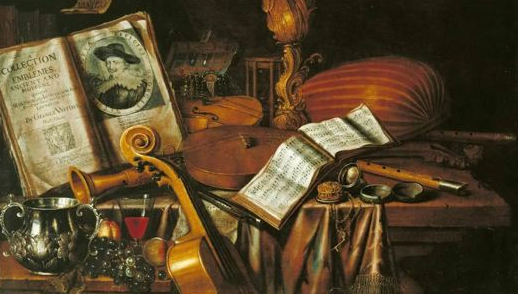

In [2]:
temp_img = Image.open("fig_data/vanitas_small.jpg")
h, w = temp_img.height, temp_img.width
transform = tr.closest_crop(h, w)
tensor, img = tr.load_image("fig_data/vanitas_small.jpg", transform)
H, W = img.height, img.width
tensor = tensor.cuda()
img

In [3]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 14, dtype=torch.float32)
#net = HighResDV2("dino_vits8", 8, dtype=torch.float32)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Upsampling based comparisons:

In [4]:
net.set_transforms([], [])
net.interpolation_mode = "bicubic"

In [5]:
bicubic_dv2 = net.forward(tensor)

In [6]:
net.set_model_stride(net.dinov2, 4)
net.interpolation_mode = "bilinear"
bicubic_ve = net.forward(tensor)

In [7]:
net.interpolation_mode = "nearest-exact"
to_blur = net.forward(tensor)

In [8]:
shifts = [i for i in range(1, 3)]
fwd, inv = tr.get_shift_transforms(shifts, 'Moore')
net.set_transforms(fwd, inv)
reference = net.forward_sequential(tensor)

In [9]:
ref_features = tr.to_numpy(reference)
ref_features = ref_features.reshape((net.feat_dim, H * W))
ref_features = ref_features.T
ref_features_rescale = rescale_pca(ref_features)
ref_features_spatial = ref_features_rescale.reshape((H, W, net.feat_dim))

We rescale both feature arrays to be between 0 and 1 so we can compare them - this isn't perfect but there's not absolute reference scale and we assume the features will be somewhat similar. Then we measure the difference between the feature array and the highest-resolution reference (Hybrid-Dv2)

In [10]:
maes = []
diffs = []

for i, features in enumerate([bicubic_dv2, bicubic_ve, to_blur]):
    compare_features = tr.to_numpy(features)
    compare_features = compare_features.reshape((net.feat_dim, H * W))
    compare_features = compare_features.T
    compare_features = rescale_pca(compare_features)
    compare_features = compare_features.reshape((H, W, net.feat_dim))

    if i == 2:
        print(compare_features.shape)
        compare_features = gaussian_filter(compare_features, sigma=(2, 2, 0))

    diff = np.abs(ref_features_spatial - compare_features)
    mae = np.sum(diff) / (net.feat_dim * H * W)
    diffs.append(diff)
    maes.append(mae)

(294, 518, 384)


In [11]:
print(maes)

[0.0932808320802581, 0.03286985367063492, 0.03297397237229029]


(384, 294, 518)


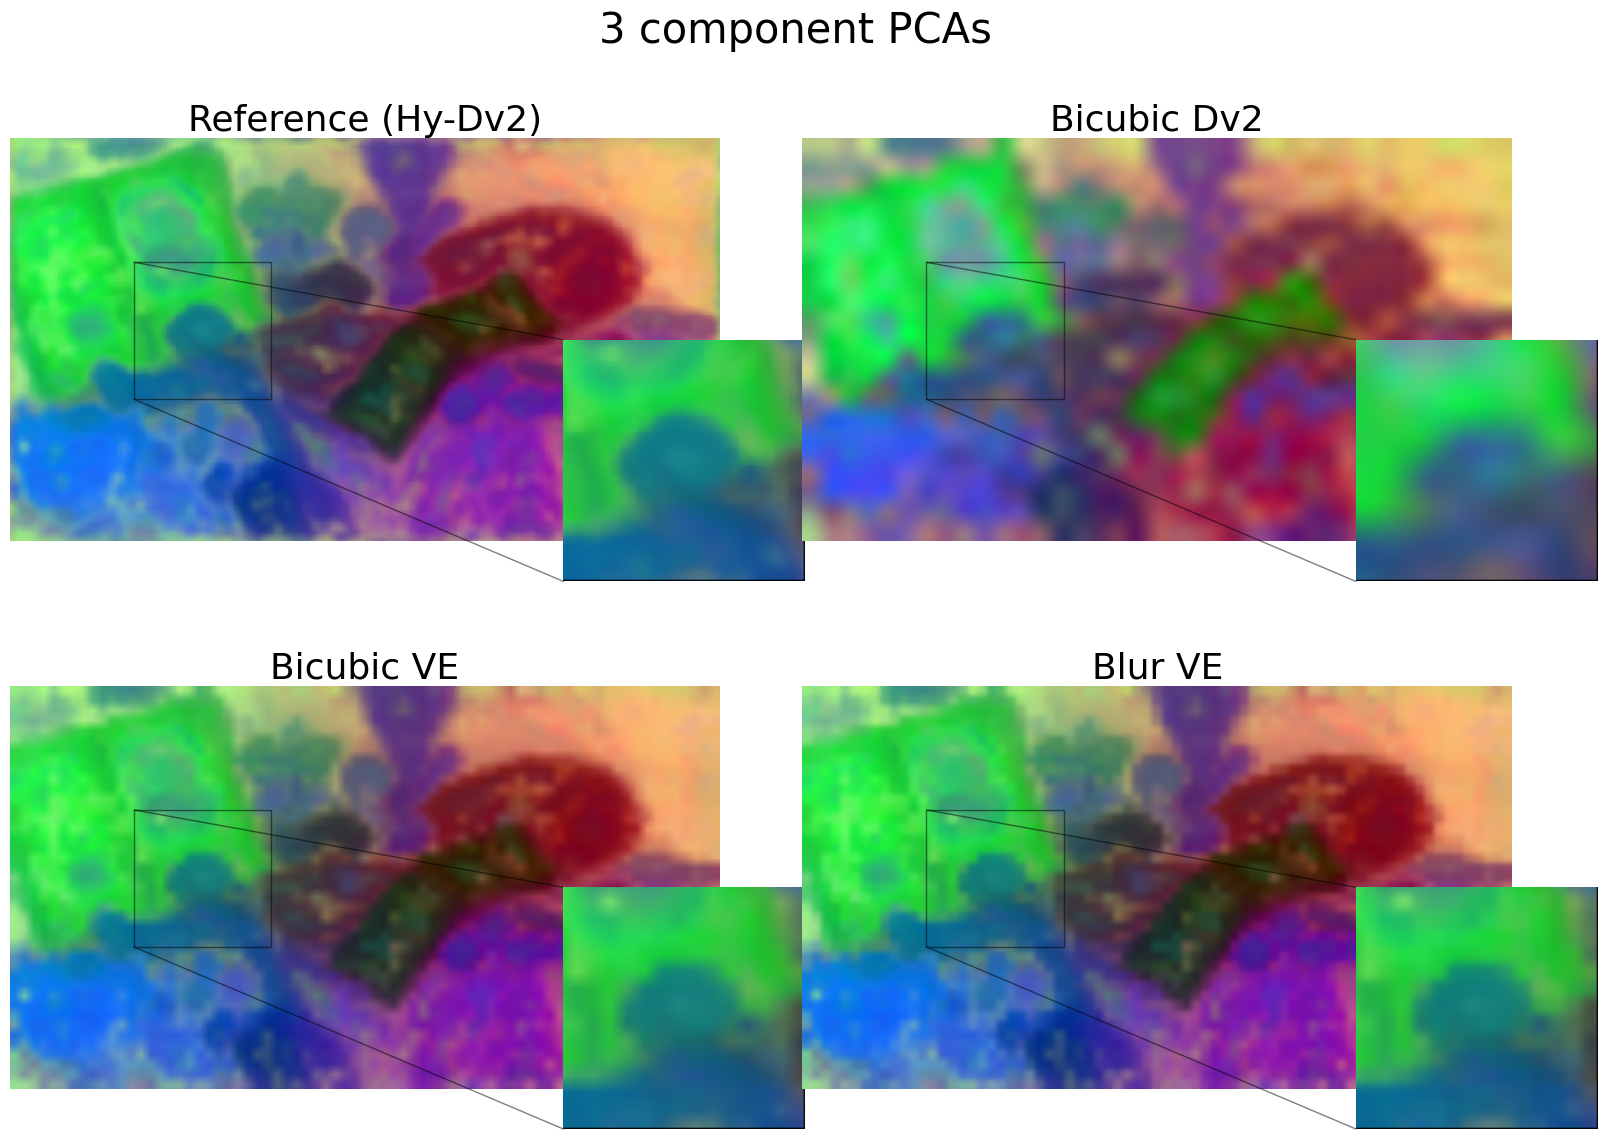

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16, 12)
titles = ["Reference (Hy-Dv2)", "Bicubic Dv2", "Bicubic VE", "Blur VE"]
plt.suptitle("3 component PCAs", fontsize=30)

for i, features in enumerate([ref_features, bicubic_dv2, bicubic_ve, to_blur]):
    if i > 0:
        compare_features = tr.to_numpy(features)
        if i == 3:
            print(compare_features.shape)
            compare_features = gaussian_filter(compare_features, sigma=(0, 2, 2))
        compare_features = compare_features.reshape((net.feat_dim, H * W))
        compare_features = compare_features.T
    else:
        compare_features = features
    pca = do_single_pca(compare_features, 3)
    pca = rescale_pca(pca)

    pca = pca.reshape((H, W, 3))

    ax = axs[i // 2, i % 2]
    ax.set_title(titles[i], fontsize=26)
    ax.set_axis_off()
    im = ax.imshow(pca)


    x0, y0, w, h = [90, 90, 100, 100]
    inset_data = np.zeros_like(pca)
    inset_data[y0:y0+h, x0:x0+w, :] = pca[y0:y0+h, x0:x0+w, :]
    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        [0.65, -0.1, 0.6, 0.6], xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_axis_off()
    axin.imshow(inset_data)
    ax.indicate_inset_zoom(axin, edgecolor="black")
    axin.set_ylim((y0 + h, y0))

plt.tight_layout()

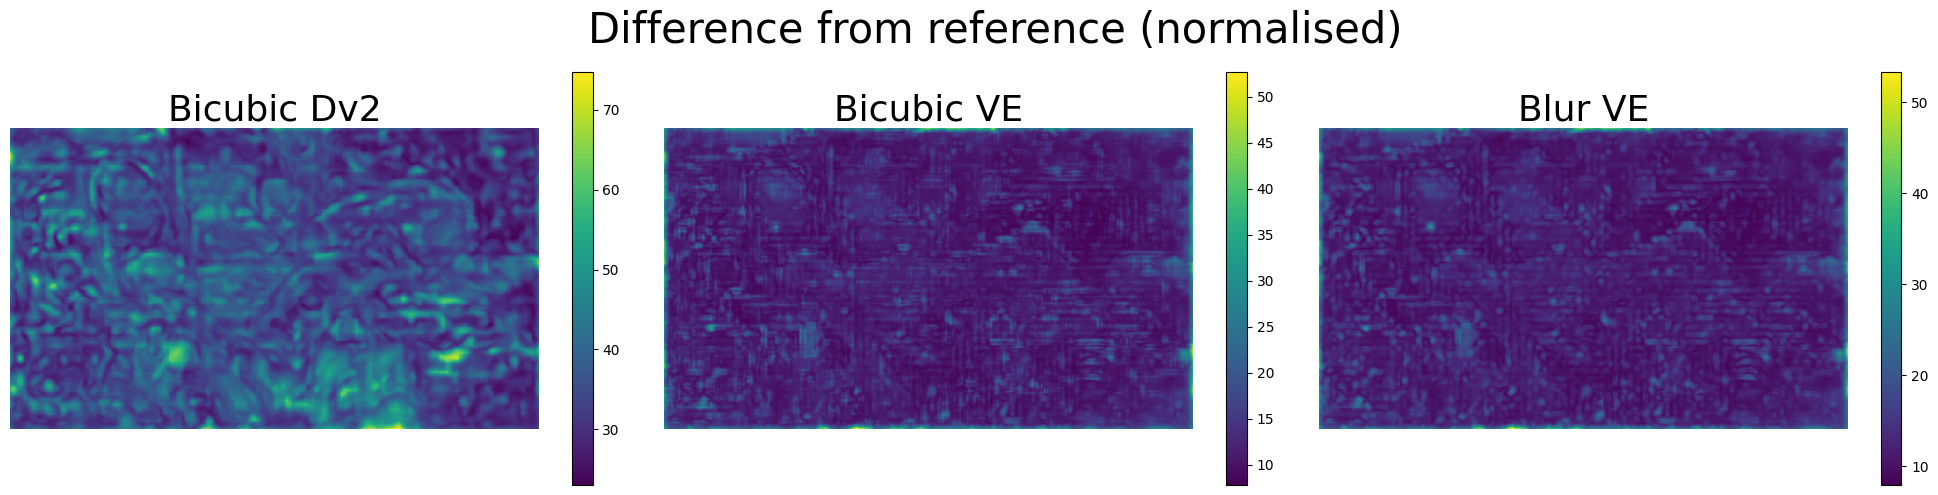

In [13]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
titles = ["Bicubic Dv2", "Bicubic VE", "Blur VE"]
plt.suptitle("Difference from reference (normalised)", fontsize=30)
for i, d in enumerate(diffs):
    total = np.sum(d, axis=-1)
    ax = axs[i]

    ax.set_title(titles[i], fontsize=26)
    ax.set_axis_off()
    im = ax.imshow(total)
    fig.colorbar(im, ax=ax)

plt.tight_layout()